In [7]:
# Imports

import os
import joblib
import pandas as pd

from src.modsec import init_modsec
from src.utils import load_data_label_vector
from src.model import train_model, test_evasion
from config import BaseConfig

In [8]:
# Setup Variables

Config = BaseConfig()
data_path = max( # use the most recent prepared data
    [os.path.join("data/prepared/", d) for d in os.listdir("data/prepared/")],
    key=os.path.getmtime,
)

print(f"Using data from {data_path}")

Using data from data/prepared/2024-03-20-12-09-33


In [9]:
# Load Data

train = load_data_label_vector(f"{data_path}/train.csv")
test = load_data_label_vector(f"{data_path}/test.csv")
train_adv = load_data_label_vector(f"{data_path}/train_adv.csv")
test_adv = load_data_label_vector(f"{data_path}/test_adv.csv")

# print shape
print(f"Train: {train.shape}, Test: {test.shape}")
print(f"Train Adv: {train_adv.shape}, Test Adv: {test_adv.shape}")

KeyError: 0

: 

Model trained successfully!
Evaluating model...
Default threshold: 0.5
FRP is currently at 0.0259
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1000
           1       0.97      0.94      0.96      1600

    accuracy                           0.95      2600
   macro avg       0.94      0.95      0.94      2600
weighted avg       0.95      0.95      0.95      2600



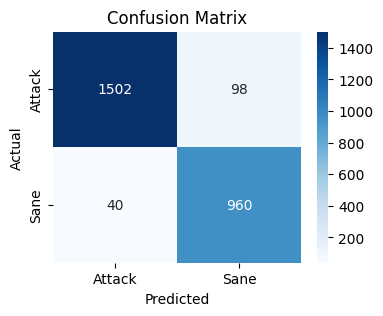

Adjusting threshold to match desired FPR of 0.01


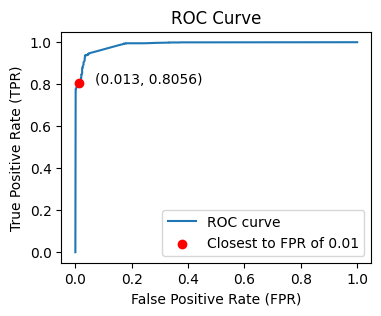

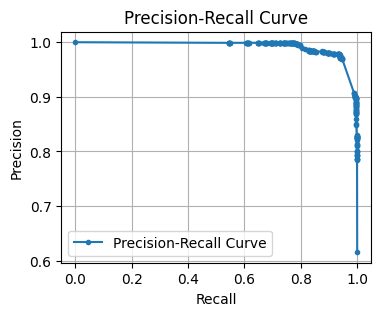

Adjusted threshold: 0.8848 with FPR of 0.013 (closest to desired FPR 0.01)
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1000
           1       0.99      0.81      0.89      1600

    accuracy                           0.88      2600
   macro avg       0.88      0.90      0.87      2600
weighted avg       0.90      0.88      0.88      2600



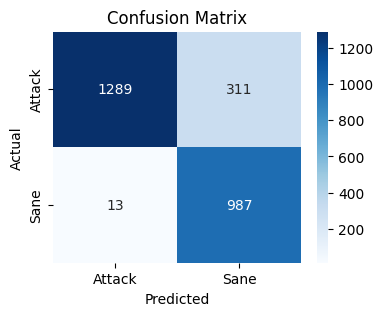

In [ ]:
# Load/Train Models

model_trained = joblib.load(f"{data_path}/model.joblib")
threshold = float(open(f"{data_path}/threshold.txt", "r").read())

model_adv_trained, threshold_adv = train_model(
    train=pd.concat([train, train_adv]).sample(frac=1).reset_index(drop=True),
    test=pd.concat([test, test_adv]).sample(frac=1).reset_index(drop=True),
    model=Config.MODEL_ADV,
    desired_fpr=Config.DESIRED_FPR,
)

In [ ]:
# Test Evasion (base model without adversarial training)

test_evasion(
    payload='SELECT SLEEP(5)#";',
    threshold=threshold,
    model=model_trained,
    engine_eval_settings={
        "max_rounds": 200,
        "round_size": 10,
        "timeout": 60,
        "threshold": 0.0,
    },
    modsec=init_modsec(),
    rule_ids=Config.RULE_IDS,
    paranoia_level=Config.PARANOIA_LEVEL,
)

Payload: SELECT SLEEP(5)#";
Vec: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
Confidence: 0.9875


[!] Max number of iterations reached
Reached confidence 0.6114619108113437
with payload
SELecT
sLeep(0x5) ||  (SELECT 0x0)#";1':9
Min payload: b'SELecT\nsLeep(0x5) \x0b||  (SELECT 0x0)#";1\':9'
Min confidence: 0.61146
Reduced confidence from 0.9875 to 0.61146 (reduction of 0.37604)

Evasion successful


In [ ]:
# Test Evasion (adversarially trained model)

test_evasion(
    payload='SELECT SLEEP(5)#";',
    threshold=threshold,
    model=model_adv_trained,
    engine_eval_settings={
        "max_rounds": 200,
        "round_size": 10,
        "timeout": 60,
        "threshold": 0.0,
    },
    modsec=init_modsec(),
    rule_ids=Config.RULE_IDS,
    paranoia_level=Config.PARANOIA_LEVEL,
)

Payload: SELECT SLEEP(5)#";
Vec: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
Confidence: 0.98793


[!] Max number of iterations reached
Reached confidence 0.7794448262945626
with payload
SELECT SLEEP((SELECT0x5))   ||  	0x0#";
Min payload: b'SELECT SLEEP((SELECT\x0c0x5))   ||  \t0x0#";'
Min confidence: 0.77944
Reduced confidence from 0.98793 to 0.77944 (reduction of 0.20849)

Evasion successful
